# Social Media Analytics

## 1. Load Library

In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from textblob import TextBlob
from textblob import Word

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load Datasets

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [2]:
df = pd.read_csv('tweets.csv')

## 3. Sneak Peak to Data

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
#Terdapat 14485 rows dan 15 kolom
df.shape

(14485, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 15 columns):
tweet_id                        14485 non-null int64
airline_sentiment               14485 non-null object
airline_sentiment_confidence    14485 non-null float64
negativereason                  9082 non-null object
negativereason_confidence       10416 non-null float64
airline                         14485 non-null object
airline_sentiment_gold          40 non-null object
name                            14485 non-null object
negativereason_gold             32 non-null object
retweet_count                   14485 non-null int64
text                            14485 non-null object
tweet_coord                     1007 non-null object
tweet_created                   14485 non-null object
tweet_location                  9798 non-null object
user_timezone                   9710 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [7]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.448500e+04,14485.000000,10416.000000,14485.000000
mean,5.692072e+17,0.899958,0.637874,0.083397
std,7.756739e+14,0.162961,0.330636,0.749632
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685515e+17,0.692300,0.360375,0.000000
50%,5.694398e+17,1.000000,0.670600,0.000000
75%,5.698811e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## 4. Handling Missing Values

In [8]:
missing_count = df.isnull().sum()

In [9]:
missing_percentage = missing_count / len(df) * 100

In [10]:
missing_percentage

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.300656
negativereason_confidence       28.091129
airline                          0.000000
airline_sentiment_gold          99.723852
name                             0.000000
negativereason_gold             99.779082
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.047981
tweet_created                    0.000000
tweet_location                  32.357611
user_timezone                   32.965136
dtype: float64

In [11]:
#Ada 3 features yang nilai missingnya diatas 90%, features tsb akan saya drop
dropped = ['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord']
df.drop(columns=dropped, inplace=True)

In [12]:
#Untuk features yang tersisa, nilai missing values akan saya biarkan untuk analisis saya selanjutnya
#Kecuali feature negativereason_confidence yang missing values akan saya isi dengan 0
df['negativereason_confidence'] = df['negativereason_confidence'].fillna(0)

## 5. Data Preprocessing
- Saya melakukan preprocessing ini agar tweet menjadi bersih dan bisa dilakukan feature extraction.
- Data preprocessing ini hanya dilakukan untuk feature text.

### 5.1 Drop Duplicate Tweet
- Menghapus tweet yang double untuk menghindari terjadinya misinterpretasi karena adanya data yang redundant.
- Lalu Memasukan tweet_id untuk keperluan analisis pada tahap selanjutnya.

In [14]:
tweet_unique = set()
for item in df['text']:
        tweet_unique.add(item)
new_tweet = []
for item in tweet_unique:
    new_tweet.append(item)
    df_text = pd.DataFrame(new_tweet,columns = ['new_text'])

In [15]:
tweet_id = df[df['text'].isin(df_text['new_text'].tolist())]
df_text['tweet_id'] = tweet_id['tweet_id']
df_text.head()

,new_text,tweet_id
0,@united kept me watching the safety video for ...,567588278875213824
1,@AmericanAir check your dm pls,567590027375702016
2,@united what's the hold up with flight 6475 fr...,567591480085463040
3,@JetBlue okay so anything using contactless EM...,567592368451248130
4,@JetBlue I don't know- no one would tell me wh...,567594449874587648


### 5.2 Lower Casing
- Seluruh text dibuat huruf kecil semua untuk memudahkan analisis.

In [16]:
df_text['new_text'] = df_text['new_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_text['new_text'].head()

0    @united kept me watching the safety video for ...
1                       @americanair check your dm pls
2    @united what's the hold up with flight 6475 fr...
3    @jetblue okay so anything using contactless em...
4    @jetblue i don't know- no one would tell me wh...
Name: new_text, dtype: object

### 5.3 Punctuation Removal
- Menghapus segala jenis punctuation karena characters ini tidak akan saya ikutkan ke dalam analisis saya.

In [17]:
df_text['new_text'] = df_text['new_text'].str.replace('[^\w\s]','')
df_text.head()

,new_text,tweet_id
0,united kept me watching the safety video for t...,567588278875213824
1,americanair check your dm pls,567590027375702016
2,united whats the hold up with flight 6475 from...,567591480085463040
3,jetblue okay so anything using contactless emv...,567592368451248130
4,jetblue i dont know no one would tell me where...,567594449874587648


### 5.4 Stopwords Removal

In [18]:
stop = stopwords.words('english')
df_text['new_text'] = df_text['new_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_text['new_text'].head()

0    united kept watching safety video first time f...
1                             americanair check dm pls
2                united whats hold flight 6475 slc den
3    jetblue okay anything using contactless emv wo...
4    jetblue dont know one would tell coming would ...
Name: new_text, dtype: object

### 5.5 Frequent Word Removal

In [19]:
freq = pd.Series(' '.join(df_text['new_text']).split()).value_counts()[:10]
freq = list(freq.index)
df_text['new_text'] = df_text['new_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df_text['new_text'].head()

0    kept watching safety video first time forever ...
1                                         check dm pls
2                              whats hold 6475 slc den
3    okay anything using contactless emv work inter...
4    dont know one would tell coming would guess th...
Name: new_text, dtype: object

### 5.6 Rare Words Removal
- Karena kata-kata ini jarang muncul maka bisa jadi hubungan asosiasi dengan kata lainya didominasi oleh noise.

In [20]:
rare_word = pd.Series(' '.join(df_text['new_text']).split()).value_counts()[-10:]
rare_word = list(rare_word.index)
df_text['new_text'] = df_text['new_text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df_text['new_text'].head()

0    kept watching safety video first time forever ...
1                                         check dm pls
2                              whats hold 6475 slc den
3    okay anything using contactless emv work inter...
4    dont know one would tell coming would guess th...
Name: new_text, dtype: object

### 5.7 Spelling Correction
- Hal ini untuk memudahkan kita dalam analisis karena kita bisa mengurangi kata yang misspelling.

In [21]:
df_text['new_text'][:5].apply(lambda x: str(TextBlob(x).correct()))
df_text.head()

,new_text,tweet_id
0,kept watching safety video first time forever ...,567588278875213824
1,check dm pls,567590027375702016
2,whats hold 6475 slc den,567591480085463040
3,okay anything using contactless emv work inter...,567592368451248130
4,dont know one would tell coming would guess th...,567594449874587648


### 5.8 Tokenization
- memecah-mecah kalimat menjadi satu persatu kata.

In [22]:
TextBlob(df_text['new_text'][1]).words

WordList(['check', 'dm', 'pls'])

### 5.9 Lematization
- Mengubah kata menjadi kata dasar

In [23]:
df_text['new_text'] = df_text['new_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df_text['new_text'].head()

0    kept watching safety video first time forever ...
1                                         check dm pls
2                              whats hold 6475 slc den
3    okay anything using contactless emv work inter...
4    dont know one would tell coming would guess th...
Name: new_text, dtype: object

## 6. Feature Extraction

### 6.1 Jumlah Kata
- Mengekstract jumlah kata dari tweet.

In [24]:
df_text['word_count'] = df_text['new_text'].apply(lambda x: len(str(x).split(" ")))
df_text.head()

,new_text,tweet_id,word_count
0,kept watching safety video first time forever ...,567588278875213824,9
1,check dm pls,567590027375702016,3
2,whats hold 6475 slc den,567591480085463040,5
3,okay anything using contactless emv work inter...,567592368451248130,13
4,dont know one would tell coming would guess th...,567594449874587648,11


### 6.2 Jumlah Kata Numerik
- Menghitung jumlah numerik yang ada di tweet. 

In [25]:
df_text['numerik'] = df_text['new_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df_text.head()

,new_text,tweet_id,word_count,numerik
0,kept watching safety video first time forever ...,567588278875213824,9,0
1,check dm pls,567590027375702016,3,0
2,whats hold 6475 slc den,567591480085463040,5,1
3,okay anything using contactless emv work inter...,567592368451248130,13,0
4,dont know one would tell coming would guess th...,567594449874587648,11,0


### 6.3 Jumlah Karakter
- Menghitung jumlah character atau huruf dalam tweet.

In [26]:
df_text['char_count'] = df_text['new_text'].str.len()
df_text.head()

,new_text,tweet_id,word_count,numerik,char_count
0,kept watching safety video first time forever ...,567588278875213824,9,0,54
1,check dm pls,567590027375702016,3,0,12
2,whats hold 6475 slc den,567591480085463040,5,1,23
3,okay anything using contactless emv work inter...,567592368451248130,13,0,95
4,dont know one would tell coming would guess th...,567594449874587648,11,0,63


### 6.3 Merge df_text dan df
- Menggabungkan df_text yaitu text yang sudah dilakukan cleansing dengan df awal dengan inner join.
- Lalu mendrop beberapa kolom karena tidak saya masukan ke dalam analisis.

In [27]:
df_final = pd.merge(df, df_text, how='inner', on='tweet_id')

In [28]:
#Beberapa kolom akan saya drop
dropped_2 = ['tweet_id', 'text']
df_final.drop(columns=dropped_2, inplace=True)

### 6.4 Extract Date
- Saya akan menambahkan fitur tahun, bulan, hari, jam, dan menit kedalam data.
- Dibagian ini agak lama ngerunya, jadi sabar yak kak ;)

In [30]:
#extract tahun
tahun = []
for i in range(len(df_final)):
    a = df_final['tweet_created'].str.split('-')[i][0]
    tahun.append(a)
df_final['tahun'] = tahun

In [31]:
#extract bulan
bulan = []
for i in range(len(df_final)):
    a = df_final['tweet_created'].str.split('-')[i][1]
    bulan.append(a)
df_final['bulan'] = bulan

In [32]:
#extract hari dan jam
hari = []
for i in range(len(df_final)):
    a = df_final['tweet_created'].str.split('-')[i][2]
    hari.append(a)
df_final['hari'] = hari

In [33]:
#extract hari
hari2 = []
for i in range(len(df_final)):
    a = df_final['hari'].str.split(' ')[i][0]
    hari2.append(a)
df_final['hari_2'] = hari2

In [34]:
#extract jam
jam = []
for i in range(len(df_final)):
    a = df_final['hari'].str.split(' ')[i][1]
    jam.append(a)
df_final['jam'] = jam

In [35]:
#extract jam
jam_2 = []
for i in range(len(df_final)):
    a = df_final['jam'].str.split(':')[i][0]
    jam_2.append(a)
df_final['jam_2'] = jam_2

In [36]:
#extract menit
menit = []
for i in range(len(df_final)):
    a = df_final['jam'].str.split(':')[i][1]
    menit.append(a)
df_final['menit'] = menit

In [37]:
#drop kolom hari, jam, dan tweet_created
# #lalu rename hari_2 menjadi hari dan jam_2 menjadi jam
df_final.drop(columns=['hari', 'jam'], inplace=True)
df_final.drop(columns=['tweet_created'], inplace=True)
df_final.rename(columns={
    'hari_2':'hari',
    'jam_2':'jam'
}, inplace=True)

In [38]:
#Convert tahun, bulan, hari, jam, menit ke numerik
df_final['tahun'] = pd.to_numeric(df_final['tahun'])
df_final['bulan'] = pd.to_numeric(df_final['bulan'])
df_final['hari'] = pd.to_numeric(df_final['hari'])
df_final['jam'] = pd.to_numeric(df_final['jam'])
df_final['menit'] = pd.to_numeric(df_final['menit'])

## 7. Exploratory Data Analyisis

In [39]:
df_final.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,tweet_location,user_timezone,new_text,word_count,numerik,char_count,tahun,bulan,hari,jam,menit
0,neutral,1.0,NaN,0.0000,Delta,JetBlueNews,0,USA,Sydney,kept watching safety video first time forever ...,9,0,54,2015,2,16,23,36
1,negative,1.0,Can't Tell,0.6503,Delta,nesi_1992,0,undecided,Pacific Time (US & Canada),check dm pls,3,0,12,2015,2,16,23,43
2,negative,1.0,Late Flight,0.3460,United,CPoutloud,0,"Washington, DC",NaN,whats hold 6475 slc den,5,1,23,2015,2,16,23,48
3,negative,1.0,Late Flight,1.0000,United,brenduch,0,NaN,Buenos Aires,okay anything using contactless emv work inter...,13,0,95,2015,2,16,23,52
4,negative,1.0,Customer Service Issue,0.3451,Southwest,VahidESQ,0,"Los Angeles, CA",Pacific Time (US & Canada),dont know one would tell coming would guess th...,11,0,63,2015,2,17,0,0


### 7.1 Univariate Exploratory Data Analysis

#### 7.1.1 Distribusi dari airline_sentiment dan nilai confidencenya

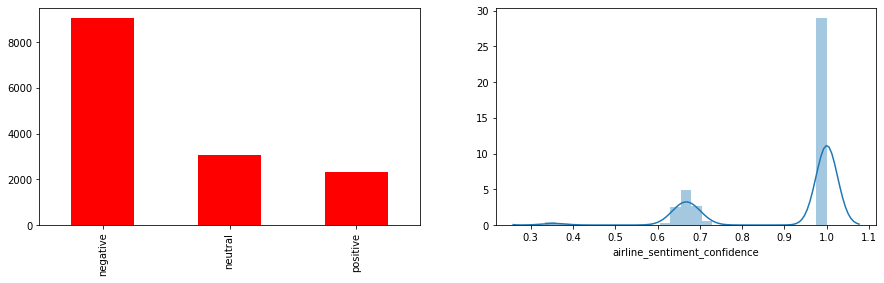

In [40]:
#Melihat distribusi dari airline_sentiment dan nilai confidencenya
f = plt.figure(figsize=(15,4))

f.add_subplot(1,2,1)
df_final['airline_sentiment'].value_counts().plot('bar', color='red')

f.add_subplot(1,2,2)
sns.distplot(df_final['airline_sentiment_confidence'])

- Ternyata sentiment analysis terhadap airline secara keseluruhan didominasi oleh sentiment negative.
- Jumlah penumpang yang memberikan sentiment neutral dan positive hampir sama.
***
- Untuk nilai confidencenya sebagian besar terdistribusi di nilai 1 yang berarti tweet merepresentasikan perasaan sesungguhnya dari user. 

#### 7.1.2 Distribusi dari negative_reason dan negative_reason confidencenya

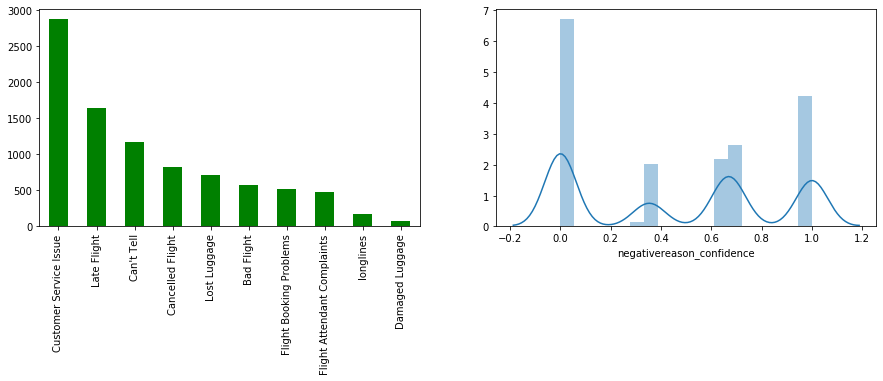

In [41]:
#Melihat distribusi dari negative_reason dan negative_reason confidencenya
f = plt.figure(figsize=(15,4))

f.add_subplot(1,2,1)
df_final['negativereason'].value_counts().plot('bar', color='green')

f.add_subplot(1,2,2)
sns.distplot(df_final['negativereason_confidence'])

- Khusus untuk sentiment negatif, alasan paling tinggi user memberikan sentiment tsb adalah karena customer services atau pelayanan dari airline itu sendiri dan alasan paling rendah adalah karena koper/bagasinya rusak.
- Perlu diingat bahwa nilai confidence 0 adalah yang tidak mengisi jadi bisa diabaikan.
- Ternyata memang nilai confidenyanya lebih banyak di angka 1.

#### 7.1.3 Distribusi dari airline

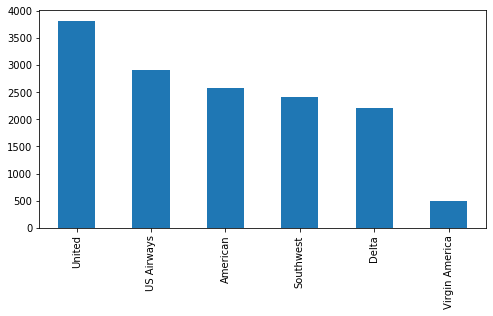

In [42]:
#Melihat distribusi dari airline
plt.figure(figsize=(8,4))
df_final['airline'].value_counts().plot('bar')

- Dari 6 airline, United airline memiliki jumlah terbanyak di data dan virgin america airline yang paling sedikit.

#### 7.1.4 Distribusi dari retweet_count

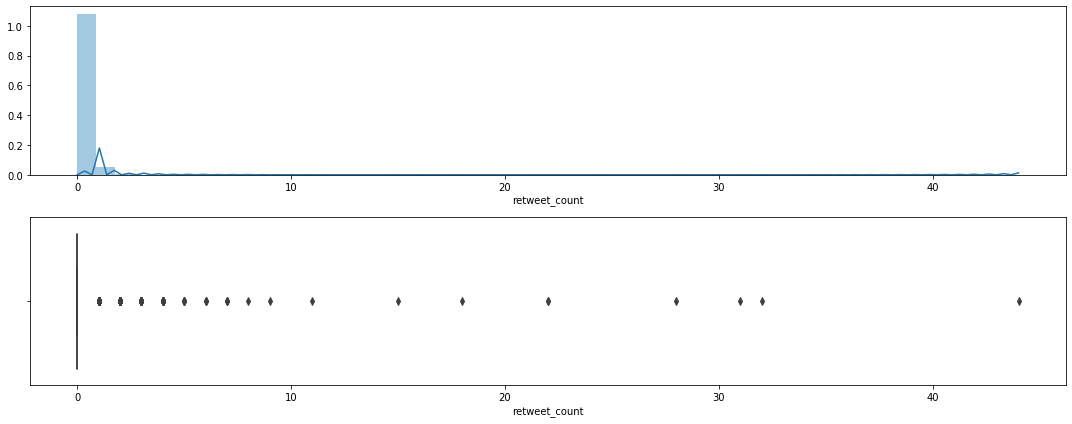

In [43]:
#Melihat distribusi dari retweet_count
f = plt.figure(figsize=(15,6))

f.add_subplot(2,1,1)
sns.distplot(df_final['retweet_count'])

f.add_subplot(2,1,2)
sns.boxplot(df_final['retweet_count'])

f.tight_layout()

- Dari keduaplot diatas dapat ditarik kesimpulan bahwa sebagian besar tweet hanya mendapatkan retweet kurang dari 10 dan hanya beberapa tweet yang memiliki retweet diatas 10.

#### 7.1.5 10 besar lokasi user membuat tweet

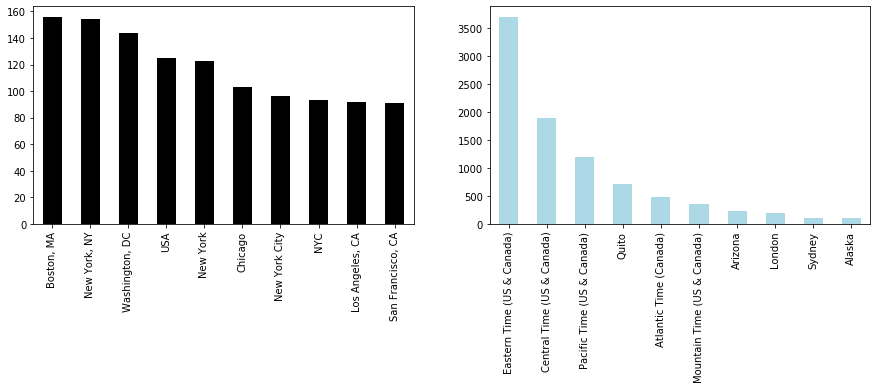

In [44]:
#Melihat 10 besar lokasi orang melakukan tweet
f = plt.figure(figsize=(15,4))

f.add_subplot(1,2,1)
df_final['tweet_location'].value_counts().head(10).plot('bar', color='black')

f.add_subplot(1,2,2)
df_final['user_timezone'].value_counts().head(10).plot('bar', color='lightblue')

- Boston, MA merupakan lokasi paling banyak orang melakukan tweet.
- Sedangkan untuk timezone melakukan tweet dikuasai oleh daerah US dan Canada.

#### 7.1.6 Distribusi dari word_count dan char_count

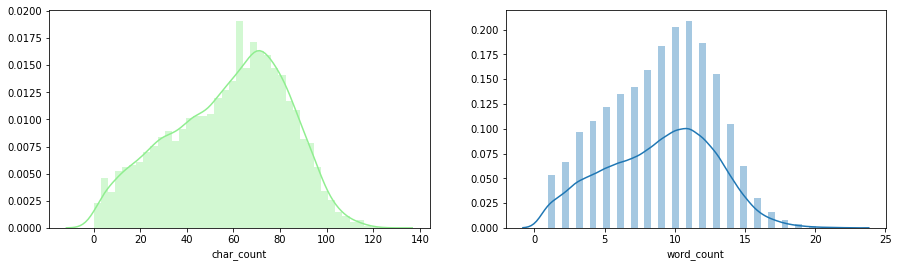

In [45]:
#Melihat distribusi dari word_count dan char_count
f = plt.figure(figsize=(15,4))

f.add_subplot(1,2,1)
sns.distplot(df_final['char_count'], color='lightgreen')

f.add_subplot(1,2,2)
sns.distplot(df_final['word_count'])

- Dapat dilihat bahwa distribusi density dari char berada di angka 60-80 char untuk sekali tweet
- Sedangkan untuk word di angka 8-12 word untuk sekali tweet.

#### 7.1.7 Distribusi dari hari, jam, dan menit

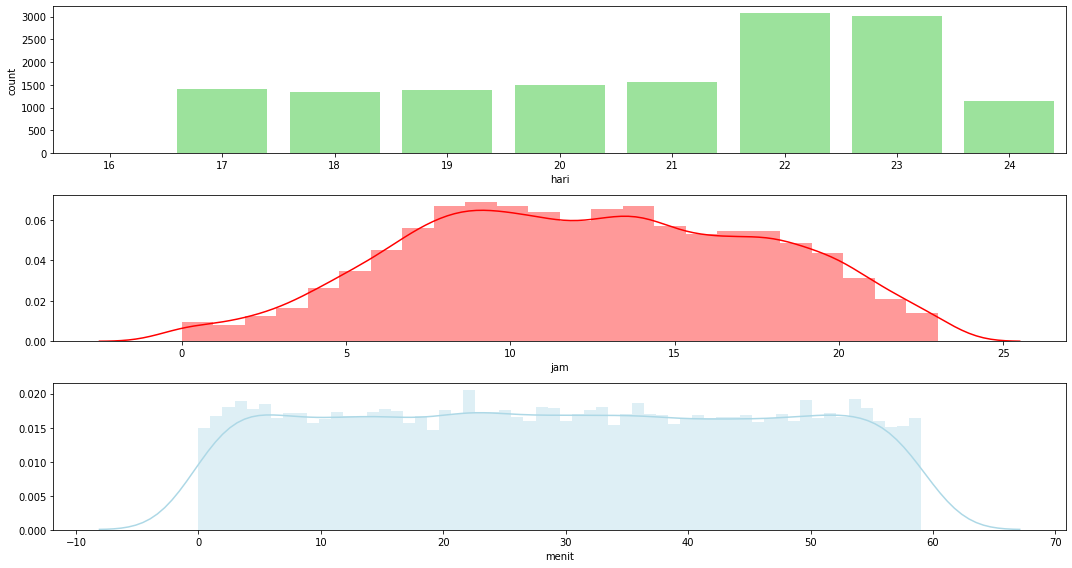

In [46]:
#Melihat distribusi dari hari, jam dan menit
f = plt.figure(figsize=(15,8))

f.add_subplot(3,1,1)
sns.countplot(df_final['hari'], color='lightgreen')

f.add_subplot(3,1,2)
sns.distplot(df_final['jam'], color='red', bins=24)

f.add_subplot(3,1,3)
sns.distplot(df_final['menit'], color='lightblue', bins=60)

f.tight_layout()

- Ternyata peak tertinggi user pada ngetweet pada hari 22 dan 23. Ada apa yak di 2 hari ini ?
- Untuk distribusi dari jam, peak hournya terdapat di kisaran jam 8 - 19.
- Untuk menit sepertinya ada tweet setiap menit dan distribusinya uniform atau merata.

### 7.1.8 Retweet Count Analysis

In [55]:
#Max retweet
df_final[df_final['retweet_count']==df_final['retweet_count'].max()]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,tweet_location,user_timezone,new_text,word_count,numerik,char_count,tahun,bulan,hari,jam,menit
1290,negative,1.0,Late Flight,1.0,US Airways,OBJ_3,44,NaN,Eastern Time (US & Canada),today usair flightled rescheduled amp notify u...,14,0,93,2015,2,17,20,6


- Ternyata tweet yang memiliki retweet_count paling banyak adalah yang memiliki sentiment negative dan karena late flight dari US Airways.
- Dapat dilihat bahwa ternyata delaynya sampai dengan 5 jam.

### 7.2 Bivariate Exploratory Data Analysis

In [47]:
df_final.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,tweet_location,user_timezone,new_text,word_count,numerik,char_count,tahun,bulan,hari,jam,menit
0,neutral,1.0,NaN,0.0000,Delta,JetBlueNews,0,USA,Sydney,kept watching safety video first time forever ...,9,0,54,2015,2,16,23,36
1,negative,1.0,Can't Tell,0.6503,Delta,nesi_1992,0,undecided,Pacific Time (US & Canada),check dm pls,3,0,12,2015,2,16,23,43
2,negative,1.0,Late Flight,0.3460,United,CPoutloud,0,"Washington, DC",NaN,whats hold 6475 slc den,5,1,23,2015,2,16,23,48
3,negative,1.0,Late Flight,1.0000,United,brenduch,0,NaN,Buenos Aires,okay anything using contactless emv work inter...,13,0,95,2015,2,16,23,52
4,negative,1.0,Customer Service Issue,0.3451,Southwest,VahidESQ,0,"Los Angeles, CA",Pacific Time (US & Canada),dont know one would tell coming would guess th...,11,0,63,2015,2,17,0,0


#### 7.2.1 Hubungan antara airline dan airline_sentiment

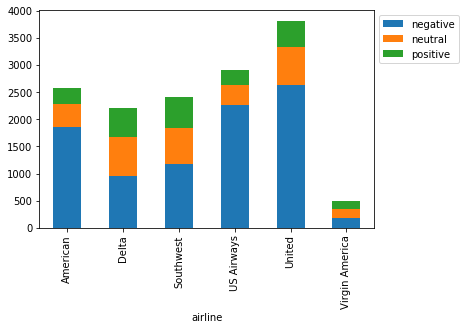

In [48]:
#Mencari hubungan antara overall airline dan airline_sentiment
airline_sent = pd.crosstab(df_final['airline'],df_final['airline_sentiment'])  
airline_sent.plot(kind='bar',stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

- Secara Overall, sebagian besar airline memiliki nilai sentiment negatif yang paling tinggi jika dibandingkan sentiment yang lain kecuali Virgin America yang memiliki sentiment proporsi yang sama.

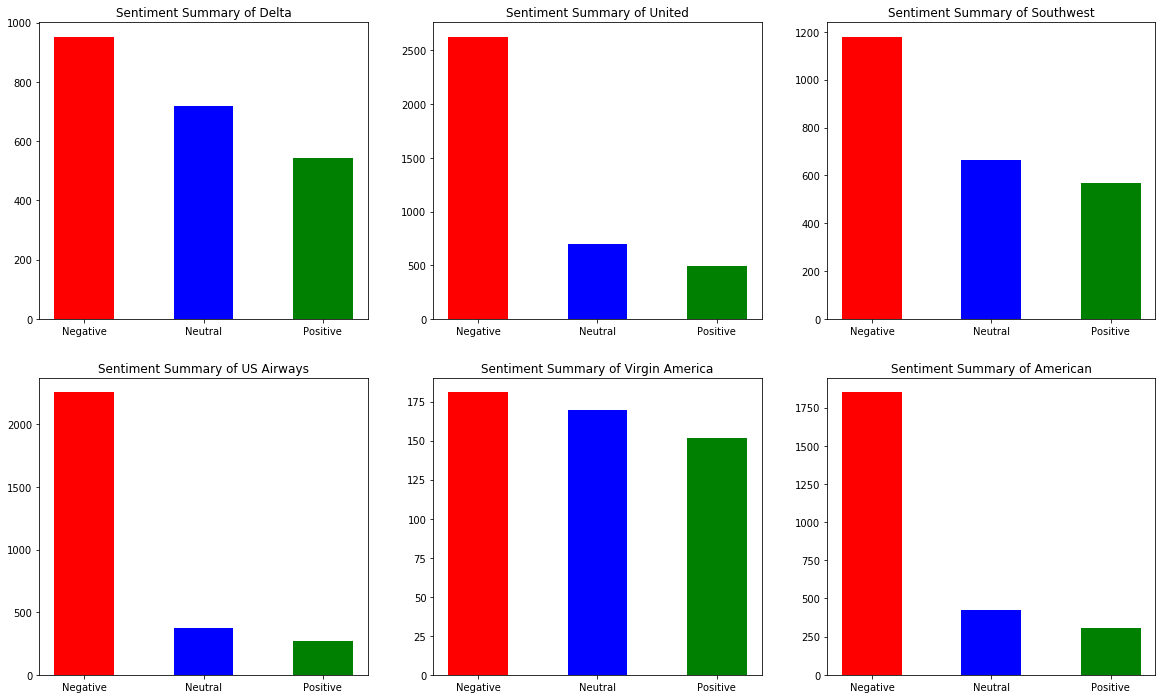

In [49]:
#Mencari hubungan antara sub airline dan airline_sentiment
def plot_sentiment_airline(Airline):
    pdf = df_final[df_final['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color = ['red','blue','green']
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Sentiment Summary of' + " " + Airline)

airline = df_final['airline'].unique()
plt.figure(1,figsize=(20,12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plot_sentiment_airline(airline[i])
plt.show()

- Secara overall, semua airline memiliki sentiment negatif yang paling tinggi jika dibandingkan dengan neutral dan positive.
- Secara overall, semua airline memiliki nilai sentiment positif yang paling kecil.
***
- Untuk airline Delta didapatkan bahwa sentiment negatif paling tinggi dengan nilai sekitar 900.
- Untuk airline United didapatkan bahwa sentiment negatif paling tinggi dengan nilai sekitar 2500.
- Untuk airline Southwest didapatkan bahwa sentiment negatif paling tinggi dengan nilai sekitar 1200.
- Untuk airline US Airways didapatkan bahwa sentiment negatif paling tinggi dengan nilai sekitar 2000.
- Untuk airline Virgin America didapatkan bahwa sentiment negatif paling tinggi dengan nilai sekitar 200.
- Untuk airline American didapatkan bahwa sentiment negatif paling tinggi dengan nilai sekitar 1750.

#### 7.2.2 Hubungan antara negative reason dan airline

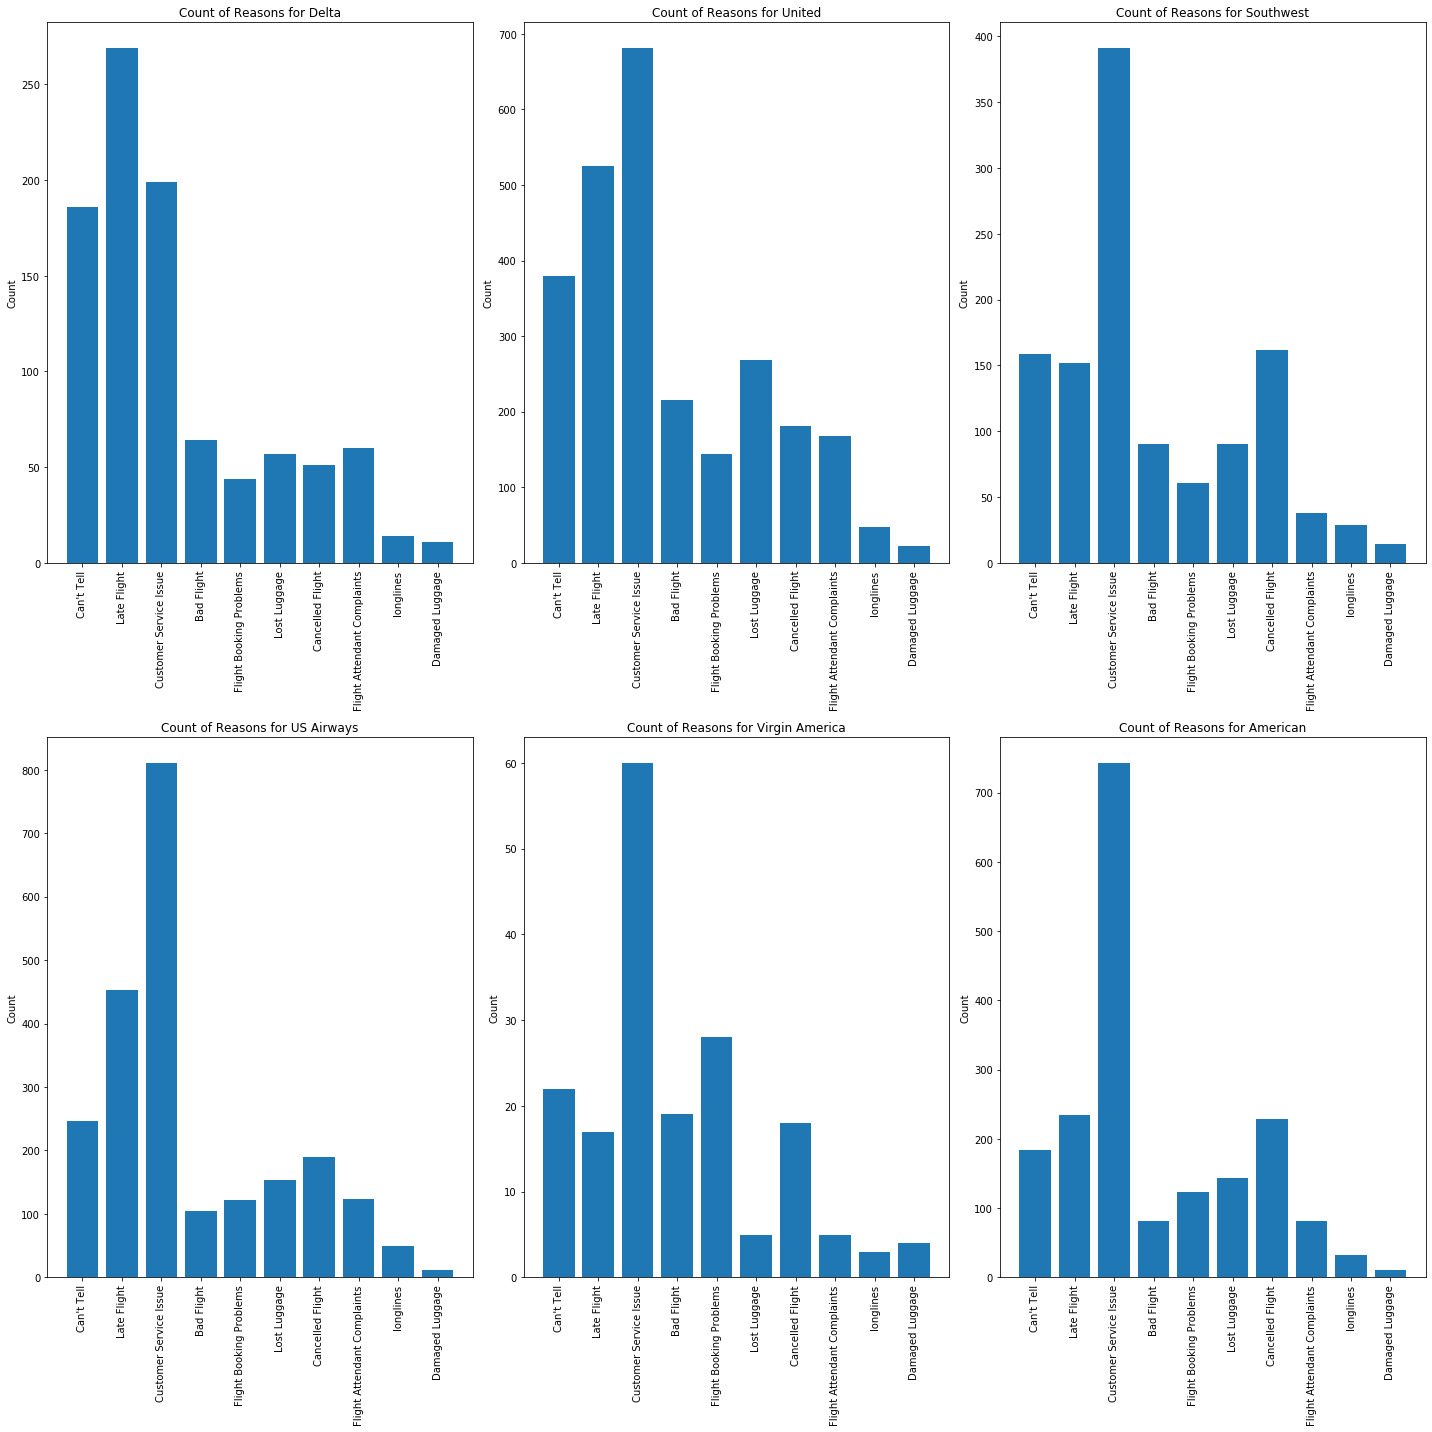

In [50]:
#Membuat distribusi negativereason dengan airline
NR_Count = dict(df['negativereason'].value_counts(sort=False))

#Membuat fungsi untuk menghitung negative reasong
def NR_Count(Airline):
    if Airline=='All':
        NR_df=df
    else:
        NR_df=df[df['airline']==Airline]
    count=dict(NR_df['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

#Membuat fungsi untuk ploting dengan airline
def plot_reason(Airline):
    NR_df=NR_Count(Airline)
    count=NR_df['count']
    Index = range(1,(len(NR_df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,NR_df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

#Plotting    
airline = df_final['airline'].unique()
plt.figure(1,figsize=(20,20), tight_layout=True)
for i in range(0,6):
    plt.subplot(2,3,i+1)
    plot_reason(airline[i])
    plt.xlabel('')
plt.show()

- Secara overall, semua airline mendapatkan sentiment negative karena masalah customer services issues.
***
- Customer services issues menjadi peringkat 1 kenapa Airline Delta mendapatkan sentiment negatif dari user sedangkan Damaged Luggage menduduki peringkat paling bawah.
- Customer services issues menjadi peringkat 1 kenapa Airline United mendapatkan sentiment negatif dari user sedangkan Damaged Luggage menduduki peringkat paling bawah.
- Customer services issues menjadi peringkat 1 kenapa Airline Southwest mendapatkan sentiment negatif dari user sedangkan Damaged Luggage menduduki peringkat paling bawah.
- Customer services issues menjadi peringkat 1 kenapa Airline US Airways mendapatkan sentiment negatif dari user sedangkan Damaged Luggage menduduki peringkat paling bawah.
- Customer services issues menjadi peringkat 1 kenapa Airline Virgin America mendapatkan sentiment negatif dari user sedangkan Longlines menduduki peringkat paling bawah.
- Customer services issues menjadi peringkat 1 kenapa Airline American mendapatkan sentiment negatif dari user sedangkan Longlines menduduki peringkat paling bawah.

#### 7.2.3 Hubunag airline_sentiment dengan variable numerik

In [71]:
airline_group = df_final.groupby('airline_sentiment').mean()
airline_group

,airline_sentiment_confidence,negativereason_confidence,retweet_count,word_count,numerik,char_count,tahun,bulan,hari,jam,menit
airline_sentiment,,,,,,,,,,,
negative,0.933464,0.731828,0.094265,8.929053,0.360482,57.806829,2015.0,2.0,21.017682,12.467897,29.172395
neutral,0.823364,0.000000,0.061947,8.890528,0.371026,57.768928,2015.0,2.0,20.817437,12.012783,29.519830
positive,0.871633,0.000000,0.070477,8.892566,0.372583,57.557370,2015.0,2.0,20.571551,12.336485,29.749463


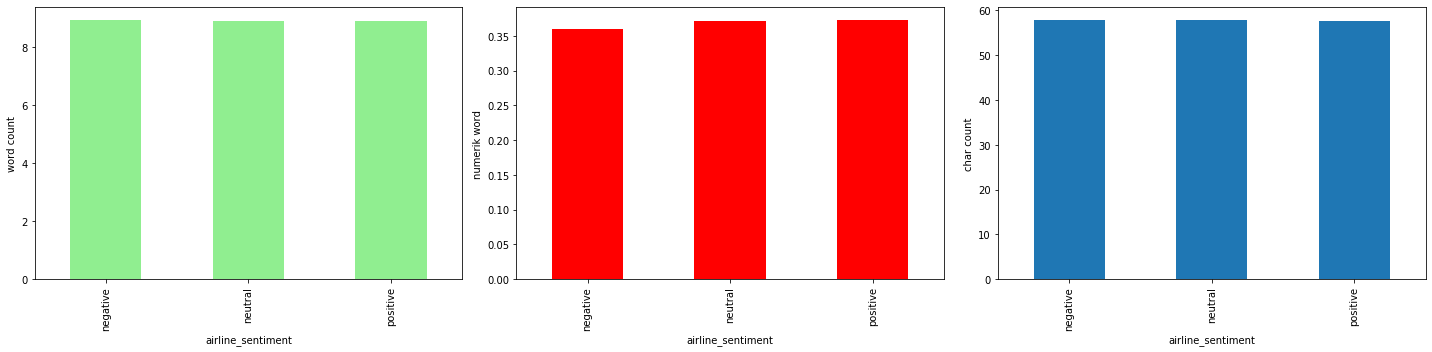

In [85]:
#Hubungan antara sentiment dengan kata
f = plt.figure(figsize=(20,5))

f.add_subplot(1,3,1)
airline_group['word_count'].plot('bar', color='lightgreen')
plt.ylabel('word count')

f.add_subplot(1,3,2)
airline_group['numerik'].plot('bar', color='red')
plt.ylabel('numerik word')

f.add_subplot(1,3,3)
airline_group['char_count'].plot('bar')
plt.ylabel('char count')

f.tight_layout()
plt.show()

- Dapat dilihat bahwa jumlah kata, jumlah huruf, jumlah angka di dalam sebuah tweet memiliki distribusi yang sama untuk sentiment negative, positive, dan neutral.

### 7.3 WordCloud
- Semakin sering sebuah kata muncul, maka akan semakin besar pula kata tersebut di WordCloud

In [94]:
#Membuat fungsi untuk membuat wordcloud
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### 7.3.1 WordCloud untuk Sentiment Negative

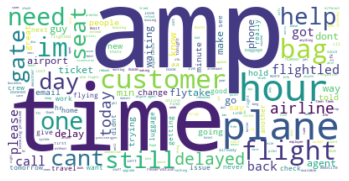

In [96]:
#define negative
negative = df_final.loc[df_final['airline_sentiment'] == 'negative']
negative_text = "".join(negative['new_text'].values)
create_word_cloud(negative_text)

- Ternyata kata yang sering muncul pada sentiment negative adalah amp, time, hour, plane, flight.

#### 7.3.2 WordCloud untuk Sentiment Positive

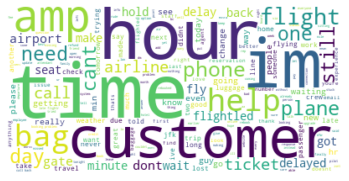

In [97]:
#define positive
positive = df_final.loc[df_final['airline_sentiment'] == 'positive']
positive_text = "".join(positive['new_text'].values)
create_word_cloud(positive_text)

- Ternyata kata yang sering muncul pada sentiment positive adalah customer, time, hour, amp, im.

#### 7.3.3 WordCloud untuk Sentiment Neutral

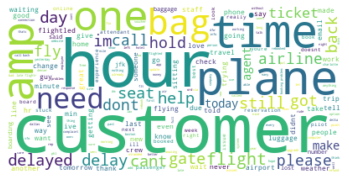

In [98]:
#define neutral
neutral = df_final.loc[df_final['airline_sentiment'] == 'neutral']
neutral_text = "".join(neutral['new_text'].values)
create_word_cloud(neutral_text)

- Ternyata kata yang sering muncul pada sentiment neutral adalah customer, time, hour, plane, bag.`
***
Untuk ketiga sentiment diatas, kata yang sering muncul hampir semua sama seperti kata customer, time, hour, amp dan plane.

In [101]:
df_final['airline'].unique()

array(['Delta', 'United', 'Southwest', 'US Airways', 'Virgin America',
       'American'], dtype=object)

#### 7.3.4 WordCloud untuk Airline Delta

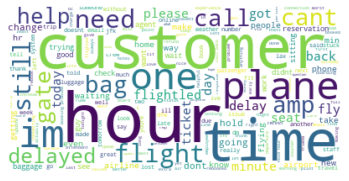

In [103]:
#define delta
delta = df_final.loc[df_final['airline'] == 'Delta']
delta_text = "".join(delta['new_text'].values)
create_word_cloud(delta_text)

- Ternyata kata yang sering muncul pada airline Delta adalah customer, time, hour, plane, flight.`

#### 7.3.5 WordCloud untuk Airline United

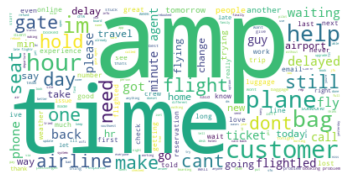

In [104]:
#define United
united = df_final.loc[df_final['airline'] == 'United']
united_text = "".join(united['new_text'].values)
create_word_cloud(united_text)

- Kata yang sering muncul pada airline United adalah amp dan time.

#### 7.3.6 WordCloud untuk Airline Southwest

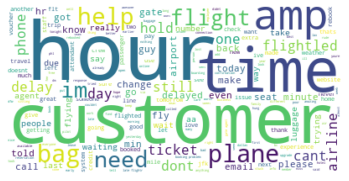

In [107]:
#define southwest
southwest = df_final.loc[df_final['airline'] == 'Southwest']
southwest_text = "".join(southwest['new_text'].values)
create_word_cloud(southwest_text)

- Kata yang sering muncul pada airline Southwest adalah hour, customer, plane, help dan time.

#### 7.3.7 WordCloud untuk Airline US Airways

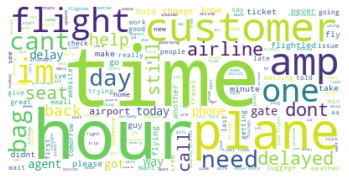

In [108]:
#define us_airways
us_airways = df_final.loc[df_final['airline'] == 'US Airways']
us_airways_text = "".join(us_airways['new_text'].values)
create_word_cloud(us_airways_text)

- Kata yang sering muncul pada airline US Airways adalah hour, customer, plane, flight dan time.

#### 7.3.8 WordCloud untuk Airline Virgin America

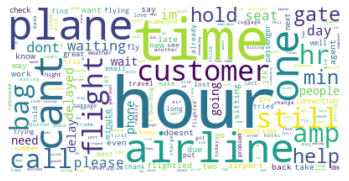

In [109]:
#define virgin
virgin = df_final.loc[df_final['airline'] == 'Virgin America']
virgin_text = "".join(virgin['new_text'].values)
create_word_cloud(virgin_text)

- Kata yang sering muncul pada airline Virgin America adalah hour, airline, plane, cant dan time.

#### 7.3.9 WordCloud untuk Airline American

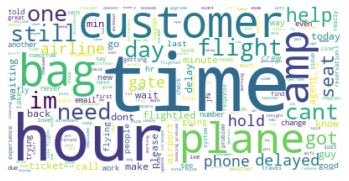

In [110]:
#define american
american = df_final.loc[df_final['airline'] == 'American']
american_text = "".join(american['new_text'].values)
create_word_cloud(american_text)

- Kata yang sering muncul pada airline American adalah hour, customer, plane, bag dan time.
***
- Dari ke-6 airline ternyata kata yang muncul juga hampir mirip seperti time, customer, hour, plane, dan flight.

## 8. Kesimpulan

Setelah melakukan EDA dapat ditarik beberapa kesimpulan yaitu:
1. Hasil sentiment analysis menunjukan bahwa sebagian besar user memberikan sentiment negative terhadap 6 airline di US.
2. Rentang pengambilan tweet dari twitter adalah dari tanggal 17 - 24 dan tanggal 22 dan 23 memiliki density yang paling tinggi untuk jumlah user yang melakukan tweet dibandingkan tanggal yang lain.
3. Alasan user memberikan sentiment negative paling banyak adalah karena customer service issues dan paling sedikit karena damaged luggage.
4. User paling banyak memberikan sentiment kepada Airline United.
5. Jumlah kata, huruf, dan angka yang digunakan dalam tweet user memiliki distribusi yang sama untuk sentiment negative, positive maupun neutral.
6. Berdasarkan analisis wordcloud untuk setiap sentiment didapatkan bahwa kata yang sering muncul hampir sama semua seperti kata customer, time, hour, amp dan plane.
7. Berdasarkan analisis wordcloud untuk setiap airline didapatkan bahwa kata yang sering muncul hampir sama semua seperti time, customer, hour, plane, dan flight.
***
Hasil dari sentiment analysis ini bisa berguna untuk:
1. Pihak Airline bisa mengetahui sumber masalah kenapa user tidak puas dengan pelayanan Airline yang bersangkutan seperti customer service issues sehingga pihak Airline bisa meningkatkan kualitas dari customer services.
2. Dengan demikian, pihak Airline bisa mengetahui preferences dari user dan bisa memberikan promo atau layanan yang maksimal sehingga user bisa loyal pada Airline.